# Оценим данные

Библиотеки для работы с данными.

In [202]:
import numpy as np
import pandas as pd

In [203]:
test = pd.read_csv('all_test.csv')
train = pd.read_csv('all_train.csv')

Примерно 88-90% от изначального объема данных.

In [204]:
train.shape , test.shape

((1095, 1614), (194, 1613))

Разделим данные на параметры и предсказание.

In [205]:
X_train = train.drop(columns=['sample_id','y'])
y_train = train['y']

Подготовим тренировочные данные, для предсказания. И отдельно колонка с названием. 

P.S. Индексы сохраняются.

In [206]:
X_test = test.drop(columns=['sample_id'])
X_name = test['sample_id']

Набор не идеально сбалансирован, однако разница в распределении классов не столь существенна, чтобы применять решения, предназначенные для сильно несбалансированных случаев.

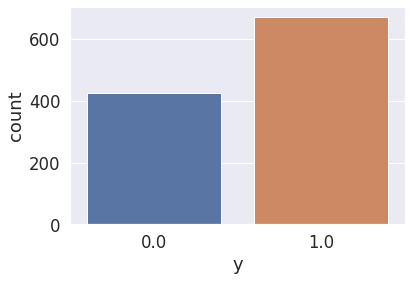

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(train['y'],label="Sum")

plt.show()

Чтобы повысить точность, стандартизируем данные для baseline моделей.

In [208]:
def standardize(train, test):
    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [209]:
X_train, X_test = standardize(X_train, X_test)

Обучаем модель. Keras Sequential API.

P.S. Помимо Sequential, есть и Functional API, но принципиального отличия между способами нет.
Класс Model (и унаследованный от него Sequential) имеет удобный интерфейс, позволяющий посмотреть, какие слои входят в модель — model.layers, входы — model.inputs, и выходы — model.outputs.


Также очень удобный метод отображения и сохранения модели — model.to_yaml.

In [210]:
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense
from tensorflow import keras

In [211]:
import warnings
warnings.filterwarnings('ignore')

Разделим тренировочный датасет на валидационные данные в соотношении 15%, объем данный не большой. Для чего это нужно. Мы передаем валидационные данные для мониторинга потерь и метрик на этих данных в конце каждой эпохи.

In [212]:
# Зарезервируем 20% примеров для валидации
X_val = X_train[-219:]
y_val = y_train[-219:]
X = X_train[:-219]
Y = y_train[:-219]

Полная метрика, для ROC-AUC.

In [213]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# Выбор гиперпараметров

**Обучаем модель. Подробнее:**

Для compile в качестве loss (минимизируемая функция потерь), берем 'binary_crossentropy', т.к. предсказываем только одно значение и это соотвествует стандартной сигнатуре (нужные кастомные метрики, могут быть вычислены из y_true, y_pred). По этой причине, у нас стоит Dense(1,...,activation='sigmoid'), если бы у нас было бы больше чем один класс для предсказания, например датасет MNIST, тогда разумеется брали 'categorical_crossentropy' с Density(10,...,activation='softmax').

Кстати, вместо 'softmax', взяли 'sigmoid'. Сигмовидные функции используются в машинном обучении для логистической регрессии и базовых реализаций нейронной сети и являются вводными единицами активации. Но для продвинутых сигмаидных функций нейронной сети они не предпочтительны из-за различных недостатков. Хотя сигмовидная функция и ее производная просты и помогают сократить время, необходимое для создания моделей, существует существенный недостаток потери информации из-за короткого диапазона производной.

Следовательно, чем больше слоев в нашей нейронной сети или чем глубже наша нейронная сеть, тем больше информации сжимается и теряется на каждом уровне, что усиливается и приводит к значительной потере данных в целом. По причине, того что это бинарная класификация, сжатие информации не страшно, т.к. один нейроный слой для сигмовидной функции.

Большинство приложений глубокого обучения в настоящее время используют ReLU вместо функций логистической активации, что мы и сделали при строительстве нейронных сетей. ReLU не лишены каких-либо недостатков, некоторые из них заключаются в том, что ReLU не центрируется на ноль и не дифференцируется в нуле, но дифференцируется в любом другом месте. По этой причине, делаем сглаживние сигмовидной функцией. 

![Sigmoid Vs ReLU](https://miro.medium.com/max/700/1*29VH_NiSdoLJ1jUMLrURCA.png)

Некоторые проблемы ReLU с нейроными сетями, могут быть решены Leaky ReLU. 

И основной вопрос, почему взяли 'sigmoid', а не 'softmax' для обучения на энтропии потерь. 

Потому, что 'softmax' используется для мультиклассификации в модели логистической регрессии, тогда как 'sigmoid' используется для двоичной классификации в модели логистической регрессии, сумма вероятностей равна единице для 'softmax'. А значит, 'softmax' не проявит себя в двоичной классификации, но затрить больше времени. 

**Что насчет оптимизатора?**
Обновить параметры выходного слоя довольно просто, но чтобы добраться до параметров слоёв за ним, приходится проходить через нелинейности, производные от которых вносят свой вклад. Явно расписанные формулы для обновления весов где-нибдуь в середине сети выглядят страшненько, ведь каждый нейрон зависит ото всех нейронов, с которымии он связан, а те — ото всех нейронов, с которыми связаны они, и так далее. Оптимизаторы нужны, чтобы решить ряд проблем, например застревание в локальных минимумах или седловых точках, сложный ландшафт целевой функции, маленькая скорость обучения, итд. Идея потимизатора, накапливать импульсы, т.е. если мы некоторое время движемся в определённом направлении, то, вероятно, нам следует туда двигаться некоторое время и в будущем. Для этого нужно уметь обращаться к недавней истории изменений каждого параметра.

Оптимизатор — один из двух аргументов, необходимых для компиляции модели Keras. Его можно настроить, или взять уже с параметрами. 
Оптимизатор SGD (стохастический оптимизатор градиентного спуска), RMSProp, Adagrad, Adadelta, Adam, Adamax, Nadam.

Выбрали для обученя модели, оптимизатор Adam, который по сути являестя RMSprop с импульсом. Параметры по умолчанию, keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False). **Он сочетает в себе и идею накопления движения и идею более слабого обновления весов для типичных признаков. **

learning_rate: float >= 0. Скорость обучения.
beta_1: float, 0 < beta < 1. Обычно близко к 1.
beta_2: float, 0 < beta < 1. Обычно близко к 1.

Adam отличается тем, что мы накапливаем значения градиента. Кроме того, мы хотим знать, как часто градиент изменяется.

Выбор оптимизатора, производился для простых датасетов, на основе вывода статьи. Я бы предложил держать качестве «золотого молотка» Adam, так как он выдаёт наилучшие результаты при минимальном подгоне параметров. Когда сеть уже более-менее отлажена, попробуйте метод Нестерова с разными параметрами.

![Оптимизатор для простых датасетов](https://hsto.org/files/270/4f7/4f5/2704f74f52764a2d83f519c16dd3bc9c.png)

Выбор гиперпараметров производился, на основе графика, и сравнения точности моделей. Основной критерий, времени экномится больше, чем увиличивается AUC от обучения.

Выбирались параметры, колличество нейроных сетей, эпох обучения, и количество образцов на обновлении градиента, теперь подробнее.

batch_size: Целое или нет. Количество образцов на обновление градиента. Если не указано, то по умолчанию параметр batch_size будет равен 32. Не указывайте размер переменной batch_size, если ваши данные представлены в виде символических тензоров, генераторов или экземпляров последовательности (поскольку они генерируют партии).

Размер партии значительно влияет на обучение. Когда вы помещаете пакет в свою сеть, происходит то, что вы усредняете градиенты. Концепция заключается в том, что если размер вашей партии достаточно велик, это обеспечит достаточно стабильную оценку того, каким будет градиент полного набора данных. Взяв образцы из вашего набора данных, вы оцените градиент при значительном снижении вычислительных затрат. Чем ниже вы идете, тем менее точной будет ваша оценка, однако в некоторых случаях эти шумовые градиенты могут фактически помочь избежать локальных минимумов. Когда оно слишком низкое, вес вашей сети может просто перепрыгнуть, если ваши данные шумят, и они могут быть неспособны к обучению или они сходятся очень медленно, что отрицательно влияет на общее время вычислений

Размер batch_size в среднем влияет только на скорость вашего обучения, а не на качество обучения. Я попытался получить большой размер batch_size, который по-прежнему умещается в памяти графического процессора, чтобы получить максимально возможную скорость.

epochs: Целое. Количество эпох для обучения модели. Эпоха — это итерация по всем предоставленным данным x и y. Обратите внимание, что в сочетании с initial_epoch, эпохи должны пониматься как «конечная эпоха». Модель не тренируется для ряда итераций, заданных эпохами, а только до тех пор, пока не будет достигнута эпоха индексов.
Подбор производился опираясь на значения результатов статьи и своих сравнений.

Колличество нейроных слоев. Dense просто обычный плотно связанный слой NN. Dense реализует операцию: output = activation(dot(input, kernel) + bias), где активация — это функция активации по элементам, переданная в качестве аргумента активации, кернел — это матрица весов, созданная слоем, а смещение — это вектор смещения, созданный слоем (применимо только в случае, если use_bias — True).

Замечание: если вход в слой имеет ранг больше 2, то он сглаживается перед исходным точечным продуктом с кернелом.

Выбор units: положительное целое число, размерность выходного пространства, для Dense. Нейронные сети - это, в основном, умножение матриц, падение, о котором вы говорите в первой части, связано не с функцией активации, а только с природой умножения матриц:

Просто говоря, считаем так: input * weights = output. Подбираем этот параметр, при уже зафиксированных значениях epoch, bach_size. Вывод делался по значениям AUC.

Источники: 

[1] Методы оптимизации нейронных сетей https://habr.com/ru/post/318970/

[2] Оптимизаторы https://ru-keras.com/optimizer/

[3] Activation function https://medium.com/@himanshuxd/
activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e

[4] Методы последовательной модели https://ru-keras.com/sequential/

[5] Основные слои https://ru-keras.com/core-layers/

[6] FAQ https://ru-keras.com/keras-faq/

# Обучение модели

In [224]:
model = Sequential()
model.add(Dense(32, init='uniform', activation='relu'))
# Установил 16, чтобы увеличить количество совпадений с результатами из задания
model.add(Dense(16, activation='relu'))    # Нужно установить 32, чтобы результат соотвествовал последний данным на Kaggel
model.add(Dense(1, init='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[METRICS])
history = model.fit(X.values, Y.values, epochs=23, batch_size=128, 
          validation_data=(X_val.values, y_val.values))

Train on 876 samples, validate on 219 samples
Epoch 1/23
876/876 [==============================] - 0s 390us/step - loss: 0.6649 - tp: 14060.8574 - fp: 2273.7144 - tn: 7693.0000 - fn: 1666.5714 - accuracy: 0.8467 - precision: 0.8609 - recall: 0.8940 - auc: 0.9235 - val_loss: 0.5856 - val_tp: 14399.5000 - val_fp: 2441.5000 - val_tn: 7721.0000 - val_fn: 1672.5000 - val_accuracy: 0.8432 - val_precision: 0.8550 - val_recall: 0.8959 - val_auc: 0.9207
Epoch 2/23
876/876 [==============================] - 0s 69us/step - loss: 0.5980 - tp: 14706.1426 - fp: 2605.7144 - tn: 7794.7144 - fn: 1682.5714 - accuracy: 0.8399 - precision: 0.8495 - recall: 0.8973 - auc: 0.9183 - val_loss: 0.5218 - val_tp: 15032.5000 - val_fp: 2725.0000 - val_tn: 7861.5000 - val_fn: 1710.5000 - val_accuracy: 0.8377 - val_precision: 0.8465 - val_recall: 0.8978 - val_auc: 0.9162
Epoch 3/23
876/876 [==============================] - 0s 74us/step - loss: 0.5483 - tp: 15337.5713 - fp: 2841.7144 - tn: 7973.1431 - fn: 1731.7142 

Сохраним модель.

In [215]:
from keras.models import load_model

model.save('keras_model.h5')    # Создает файл HDF5 ‘my_model.h5’

#del model    # Удаляет существующую модель

#model = load_model('my_model.h5')    # Возвращает скомпилированную модель

Увеличив epoch и units, увеличится значение AUC. Например, при epoch = 50, и тем же количеством слоев, можно поднять AUC **с 92.6% до 97.5%**, а с увеличением нейронного слоя units до 128, можно добиться **AUC 98.5%**. Тем не менее, нашего значения AUC достаточно, для классификации и совпадении с результатами из задания.

P.S. При большом значении результаты будут разняться.

In [216]:
print('\nhistory dict:', history.history)    # Для оценки AUC и выбора параметров. 


history dict: {'val_loss': [0.6094183565274766, 0.5397819288789409, 0.5042806807990488, 0.4976518769242448, 0.48994387053463556, 0.48487566037265134, 0.4940202308299879, 0.49596107550407653, 0.5013415488206088, 0.49818274405993285, 0.48948603337758206, 0.5055486935458772, 0.5043752696960484, 0.5025793401073647, 0.5580820178604562, 0.5114321290902352, 0.5501139232012779, 0.5719173391387887, 0.5700183693132445, 0.6187839611480225, 0.5910510253416349, 0.6365186498589712, 0.6547640741687931], 'val_tp': [576.5, 1166.0, 1747.0, 2327.0, 2912.5, 3497.0, 4076.5, 4662.5, 5250.5, 5838.5, 6435.0, 7032.0, 7629.5, 8233.5, 8835.0, 9441.5, 10052.5, 10656.0, 11273.0, 11884.0, 12498.5, 13119.5, 13743.0], 'val_fp': [256.0, 458.5, 629.5, 773.5, 897.0, 1017.0, 1117.0, 1213.5, 1305.5, 1388.0, 1472.5, 1551.0, 1627.5, 1700.0, 1759.5, 1815.5, 1873.0, 1906.0, 1953.5, 1986.0, 2017.5, 2047.0, 2071.0], 'val_tn': [154.5, 376.0, 629.0, 909.0, 1209.5, 1513.5, 1837.5, 2165.0, 2497.0, 2838.5, 3178.0, 3523.5, 3871.0, 4

Импортируем результаты из задания для сравнения и построения ROC curve, т.к. примем их за истину, как значения y_test.

In [225]:
y_test = pd.read_csv('/content/sample_submission.csv')

Совершаем предсказания для X_test.

In [226]:
y_pred = model.predict(X_test.values)

In [227]:
X_name = pd.DataFrame(X_name)
X_name['y'] = np.nan
for i in range(len(X_name)):
    X_name['y'][i] = np.around([y_pred[i][0]], decimals = 3)

Количество строк в датасете результата из задания и предсказания отличаются. По причине, различия обработки тестовых и тренировочных данных. 

**P.S.** Если в датасете результата, сохранены все строки, то такого результата можно было бы добиться следующим способом. Удаление столбцов с большим количеством NaN и +-inf, либо замена NaN, как 0 (либо одно число, если в столбце уже имеется 0) и +-inf, как большое число +-float (умещающиеся в памяти). Тем не менее, мне такой подход показался не правильным, т.к. +-inf, подобие +-бесконечности, а как известно бесконечность != бесконечности, по этой причине inf - inf = NaN, т.е. напрашивается второй вывод, NaN != NaN.  

Объединим результат предсказания с результатом из задания (удалив недостающие строки).

In [228]:
df = X_name.merge(y_test, left_on='sample_id', right_on='sample_id')

Как упоминалось ранее, результат предсказания из задания, считаем, как истинный, и по этим данным строим ROC. Для этого округлим значения до результата предсказания.

In [229]:
for i in range(len(df)):
    df['y_y'][i] = np.around([df['y_y'][i]], decimals = 0)

Построим ROC curve.

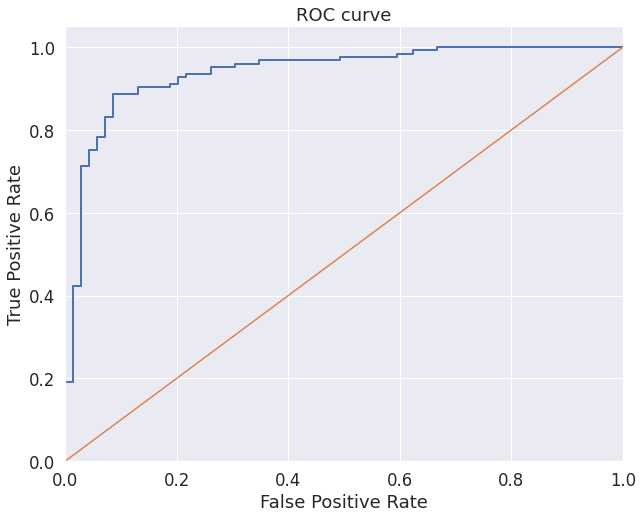

In [230]:
from sklearn.metrics import roc_curve
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(df['y_y'], model.predict(X_test).ravel(), pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Сравним отличные значения точек и выведем название образца.

In [231]:
for i in range(len(df)):
    if np.around([df['y_x'][i]], decimals = 0) != df['y_y'][i]:
        print(df['sample_id'][i])

sample_1102
sample_1109
sample_1119
sample_1133
sample_1144
sample_1155
sample_1163
sample_1165
sample_1170
sample_1188
sample_1195
sample_1200
sample_1232
sample_1237
sample_1240
sample_1244
sample_1248
sample_1250
sample_1265
sample_1266
sample_1268
sample_1286


Сохраняем результат для отправки на Kaggel.

In [232]:
X_name.to_csv('sample_test.csv')

В процетном соотношении.

In [51]:
17/164 * 100

10.365853658536585

Оценим в графическом виде, некоторые параметры модели.

In [233]:
print(history.history.keys()) 

dict_keys(['val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc'])


Визуализируем процесс тренировки, чтобы оценить, как менялись параметры, в зависимости от эпохи. 

**Итог history для accuracy:**

<Figure size 432x288 with 0 Axes>

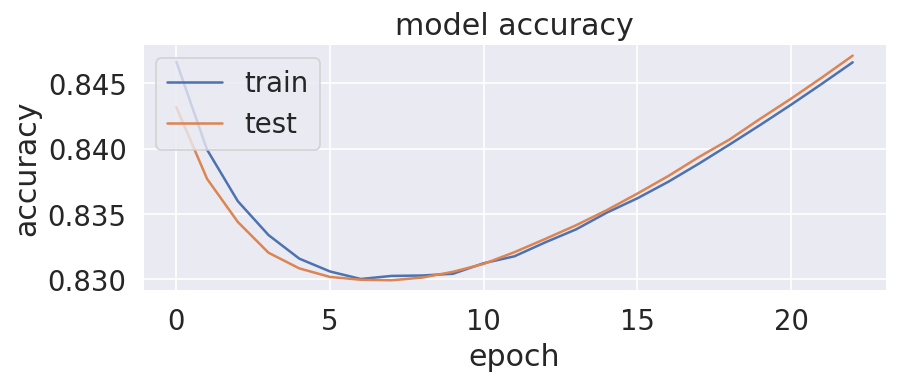

In [234]:
plt.figure(1)  
   
# Подвести итог истории для точности

plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
plt.subplot(211) 
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("accuracy.png")
plt.show()

**Итог history для loss:**

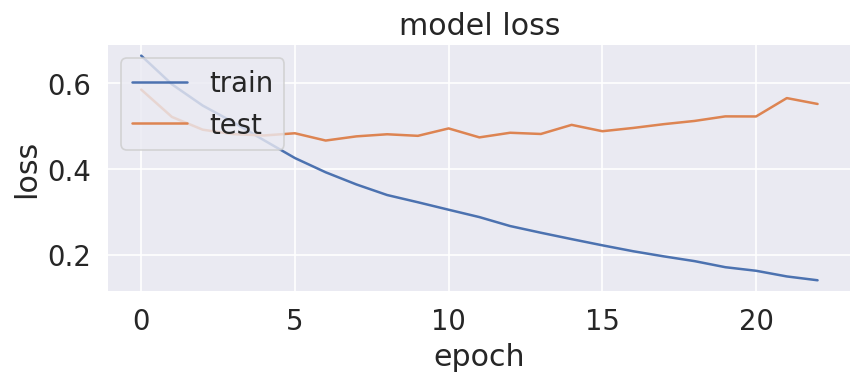

In [235]:
# Подвести итог истории для потерь 
plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.savefig("loss.png")
plt.show()

**Итог history для f1 score:**

In [251]:
f1_score=[]
val_f1_score = []
for i in range(len(history.history['precision'])):
    f1_score.append(2*(history.history['precision'][i]*history.history['recall'][i])/(history.history['precision'][i]+history.history['recall'][i]))
    val_f1_score.append(2*(history.history['val_precision'][i]*history.history['val_recall'][i])/(history.history['val_precision'][i]+history.history['val_recall'][i]))

<Figure size 432x288 with 0 Axes>

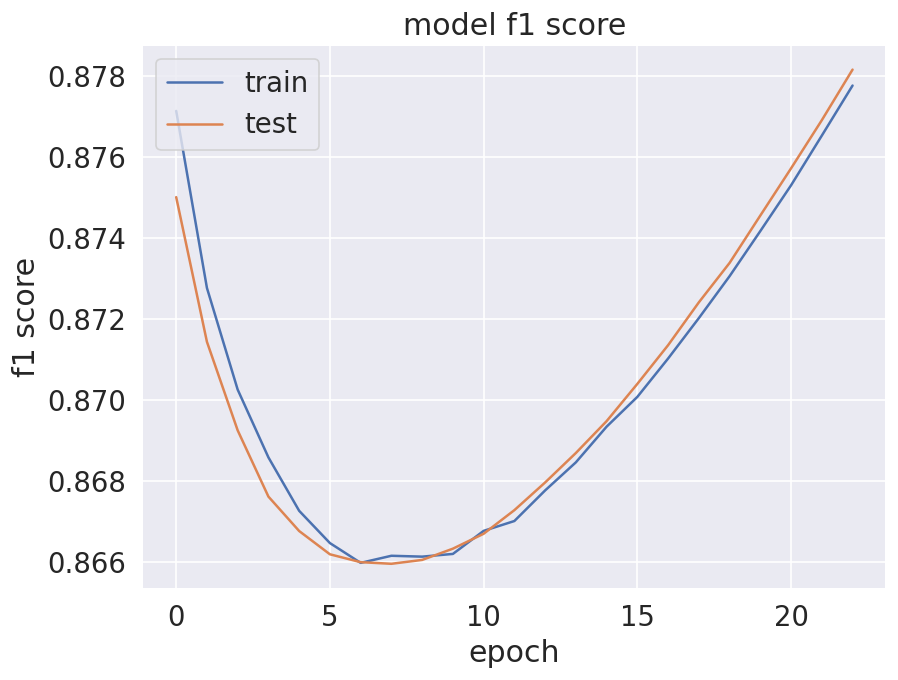

In [237]:
plt.figure(1)  
   
# # Подвести итог истории для f1 score

plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
plt.subplot() 
plt.plot(f1_score)  
plt.plot(val_f1_score)   
plt.title('model f1 score')  
plt.ylabel('f1 score')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("f1_score.png")
plt.show()

# Сравнение моделей

Без сокращений. Перекрёстная проверка. Параметр cv - cross-validated, означает вычисления значений cv раз подряд (каждый раз с разными разбиениями). Возьмем этот параметр равным количеству epoch в keras модели.

In [238]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV

Logistic Regression

In [239]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train, y_train, scoring=scoring, cv=28)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

Decision Tree

In [240]:
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train, y_train, scoring=scoring, cv=28)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()

Support Vector Machine

In [241]:
SVM = SVC(probability = True)

scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(SVM, X_train, y_train, scoring=scoring, cv=28)

sorted(scores.keys())
SVM_fit_time = scores['fit_time'].mean()
SVM_score_time = scores['score_time'].mean()
SVM_accuracy = scores['test_accuracy'].mean()
SVM_precision = scores['test_precision_macro'].mean()
SVM_recall = scores['test_recall_macro'].mean()
SVM_f1 = scores['test_f1_weighted'].mean()
SVM_roc = scores['test_roc_auc'].mean()

Linear Discriminant Analysis

In [242]:
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train, y_train, scoring=scoring, cv=28)

sorted(scores.keys())
LDA_fit_time = scores['fit_time'].mean()
LDA_score_time = scores['score_time'].mean()
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()

Quadratic Discriminant Analysis

In [243]:
QDA = QuadraticDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(QDA, X_train, y_train, scoring=scoring, cv=28)

sorted(scores.keys())
QDA_fit_time = scores['fit_time'].mean()
QDA_score_time = scores['score_time'].mean()
QDA_accuracy = scores['test_accuracy'].mean()
QDA_precision = scores['test_precision_macro'].mean()
QDA_recall = scores['test_recall_macro'].mean()
QDA_f1 = scores['test_f1_weighted'].mean()
QDA_roc = scores['test_roc_auc'].mean()

Random Forest Classifier

In [244]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train, y_train, scoring=scoring, cv=28)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

K-Nearest Neighbors

In [245]:
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train, y_train, scoring=scoring, cv=28)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()

Naive Bayes

In [246]:
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train, y_train, scoring=scoring, cv=28)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

Keras Model

In [253]:
Keras_AUC = np.around([history.history['auc'][-1:]],decimals = 6).mean()
Keras_recall = np.around([history.history['recall'][-1:]],decimals = 6).mean()
Keras_precision = np.around([history.history['precision'][-1:]],decimals = 6).mean()
Keras_accuracy = np.around([history.history['accuracy'][-1:]],decimals = 6).mean()
Keras_f1 = np.around([f1_score[-1:]],decimals = 6).mean()

**Сравниваем модели.** По результатам сравнения, наша keras модель на порядок лучше.

In [254]:
models_initial = pd.DataFrame({
    'Model'       : ['Keras Model','Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Accuracy'    : [Keras_accuracy,LR_accuracy, dtree_accuracy, SVM_accuracy, LDA_accuracy, QDA_accuracy, forest_accuracy, KNN_accuracy, bayes_accuracy],
    'Precision'   : [Keras_precision,LR_precision, dtree_precision, SVM_precision, LDA_precision, QDA_precision, forest_precision, KNN_precision, bayes_precision],
    'Recall'      : [Keras_recall,LR_recall, dtree_recall, SVM_recall, LDA_recall, QDA_recall, forest_recall, KNN_recall, bayes_recall],
    'F1_score'    : [Keras_f1,LR_f1, dtree_f1, SVM_f1, LDA_f1, QDA_f1, forest_f1, KNN_f1, bayes_f1],
    'AUC_ROC'     : [Keras_AUC,LR_roc, dtree_roc, SVM_roc, LDA_roc, QDA_roc, forest_roc, KNN_roc, bayes_roc],
    }, columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1_score,AUC_ROC
0,Keras Model,0.846621,0.857439,0.899058,0.877755,0.922766
6,Random Forest,0.786355,0.787912,0.763807,0.782426,0.851276
3,Support Vector Machine,0.784524,0.785706,0.757706,0.779282,0.847686
7,K-Nearest Neighbors,0.760668,0.763070,0.724819,0.751010,0.813054
1,Logistic Regression,0.735348,0.726570,0.718951,0.732553,0.787372
2,Decision Tree,0.720559,0.709977,0.707046,0.719983,0.707046
5,Quadratic Discriminant Analysis,0.689606,0.679534,0.643472,0.670454,0.694753
8,Bayes,0.676694,0.697748,0.702229,0.675902,0.779623
4,Linear Discriminant Analysis,0.594574,0.580352,0.583670,0.594642,0.583957
